<a href="https://colab.research.google.com/github/NicoBellico/AIFaceDetectionProyect/blob/main/FaceDetectionProyect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# importamos dependecias
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import numpy as np
import io
import html
import time
import PIL
import cv2

In [9]:
# funcion para convertir objeto de JavaScript a una imagen OpenCv
def js_to_image(js_reply):
  # decodifica una imagen en base64
  image_bytes = b64decode(js_reply.split(',')[1])
  # convierte bytes a arrays de numpy
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decodifica un array de numpy en una imagen OPENCV BGR
  img = cv2.imdecode(jpg_as_np, flags=1) 

  return img

# función para convertir la imagen del cuadro tipo rectángulo OpenCV en una cadena de bytes base64 para superponerla en la transmisión de video
def bbox_to_bytes(bbox_array):
  # convierte un array a una una imagen para PIL
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # guardamos el formato de la imagen
  bbox_PIL.save(iobuf, format='png')
  # formato para retornar un string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [10]:
# Modelo ML "Haar Cascade" explicado en la presentación en este caso modelo pre-entrenado con la libreria de CV2
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [11]:
# Esta parte del codigo es sacada de la propia pagina de Colab para poder tomar una foto:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  # desde aqui se añade como el programa procesa la imagen
  # substraemos la foto
  data = eval_js('takePhoto({})'.format(quality))
  # obtenemos la imagen en formato OpenCV
  img = js_to_image(data) 
  # imagen en escala de grises
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # obtenemos las coordenadas del rectangulo delimitador de la cara usando nuestro metodo Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # dibujamos el rectangulo delimitador de alguna cara en la imagen
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
  # Guardamos la foto
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Guardada como: photo.jpg


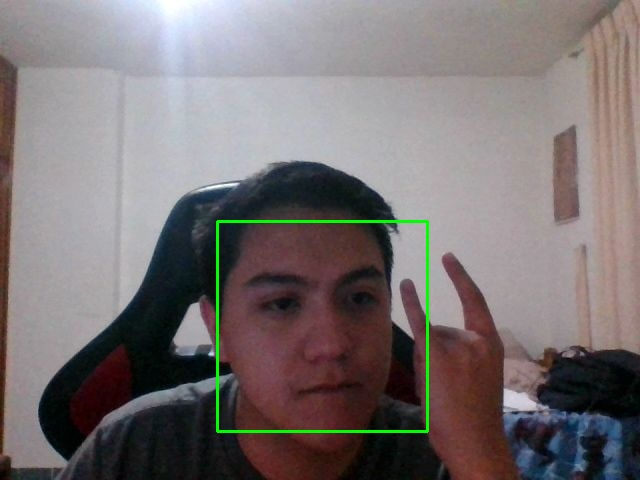

In [13]:
# iniciamos la camara y al dar click en "Capture"
try:
  filename = take_photo('photo.jpg')
  print('Guardada como: {}'.format(filename))
  
  # Mostranos la foto que acabamos de tomar
  display(Image(filename))
except Exception as err:
  # Errores apareceran si el usuario no tiene webcam o si no le dieron el permiso al navegador de usar la misma.
  print(str(err))

In [27]:
# JavaScript para crear correctamente la transmisión de video en vivo usando su cámara web como entrada
# codigo tomado del mismo colab para poder iniciar un stream con la webcam
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Estado:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'Cuando termine haga click aqui o en el video para detener la ejecucion, gracias :)</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [28]:
# empezamos la transmicion del video desde la webcam
video_stream()
# label del video
label_html = 'Capturando...'
# inicializamos el rectangulo delimitador a "vacio"
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convertimos la respuesta de JS a una imagen OpenCV
    img = js_to_image(js_reply["img"])

    # creamos una superposicion para estar al frente del video
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # imagen en escala de grises para la deteccion
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # obtenemos las coordenadas de la region de la cara
    faces = face_cascade.detectMultiScale(gray)
    #  dibujamos el rectangulo delimitador de alguna cara en la imagen
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convertimos en bytes el rectangulo delimitador
    bbox_bytes = bbox_to_bytes(bbox_array)
    # actualizamos el rectangulo delimitador para que el siguiente cuadro tenga una nueva posicion
    bbox = bbox_bytes

<IPython.core.display.Javascript object>